In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=',')
df

,latitude,longitude,data,dia_semana,mes,is_weekend,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.323152,-49.066030,2022-10-24,0,10,0,23,0,0,0.0,0,0,0,0,0,0,1
1,-22.330302,-49.106223,2023-03-02,3,3,0,12,0,0,0.0,0,0,0,0,0,0,1
2,-22.335932,-49.067196,2025-01-08,2,1,0,17,0,0,0.0,0,0,0,0,0,0,1
3,-22.327175,-49.116669,2024-01-23,1,1,0,19,0,0,0.0,0,0,0,0,0,0,1
4,-22.330951,-49.088352,2022-09-19,0,9,0,20,0,0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827084,-22.309319,-49.073527,2025-01-16,3,1,0,15,0,0,0.0,0,0,1,0,0,0,0
827085,-22.325896,-49.079704,2024-05-17,4,5,0,9,0,0,0.0,0,0,0,0,0,0,1
827086,-22.351893,-49.032062,2024-02-01,3,2,0,13,0,0,0.0,0,0,0,0,0,0,1
827087,-22.291783,-49.071040,2022-07-10,6,7,1,9,0,0,0.0,0,0,0,0,0,0,1


In [3]:
X = df.drop(columns=['Sinistro', 'data']) 
 
y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (578962, 15)
Tamanho do conjunto de teste: (248127, 15)


In [4]:
xgb_model = xgb.XGBClassifier(random_state=8,  
                              eval_metric='logloss',
                              scale_pos_weight = 100,
                              learning_rate=0.05,
                              n_estimators=300,
                              max_depth=5,
                              use_label_encoder=False)

xgb_model.fit(X_train, y_train)

c:\Users\pirsp\Documents\TCC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:29:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



--- Matriz de Confusão ---


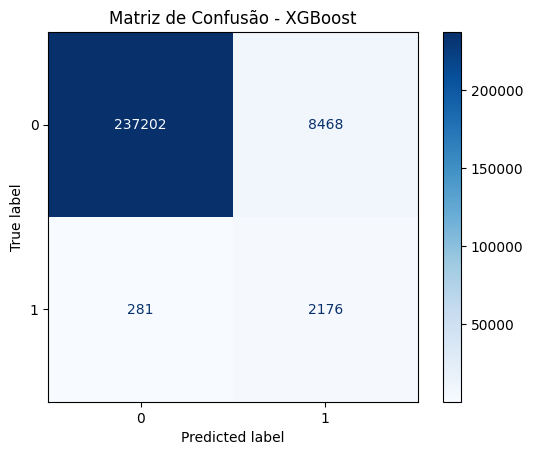

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    245670
           1       0.20      0.89      0.33      2457

    accuracy                           0.96    248127
   macro avg       0.60      0.93      0.66    248127
weighted avg       0.99      0.96      0.98    248127

--- AUC (XGBoost) ---
0.9674


In [5]:
LIMIAR_ESCOLHIDO = 0.5

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# Limiar alterado
y_pred_final = (y_prob_xgb >= LIMIAR_ESCOLHIDO).astype(int)

print("\n--- Matriz de Confusão ---")
cf_matrix = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - XGBoost")
plt.show()
print(classification_report(y_test, y_pred_final))


auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"--- AUC (XGBoost) ---")
print(f"{auc_xgb:.4f}")

### Curvas Precision-Recall (PR-AUC) 1_2

Average Precision (AP) / PR-AUC: 0.8654


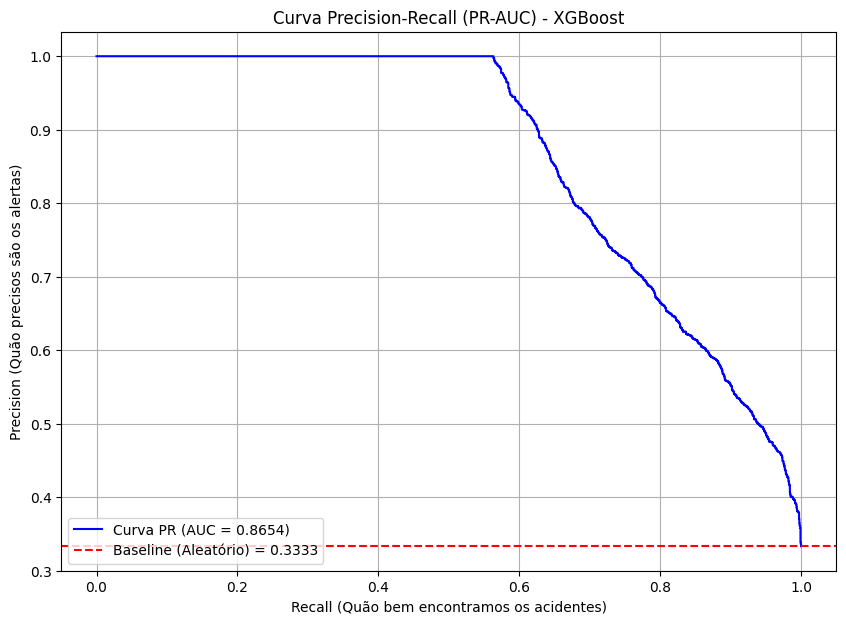

In [6]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Curvas Precision-Recall (PR-AUC) 1_4

Average Precision (AP) / PR-AUC: 0.7887


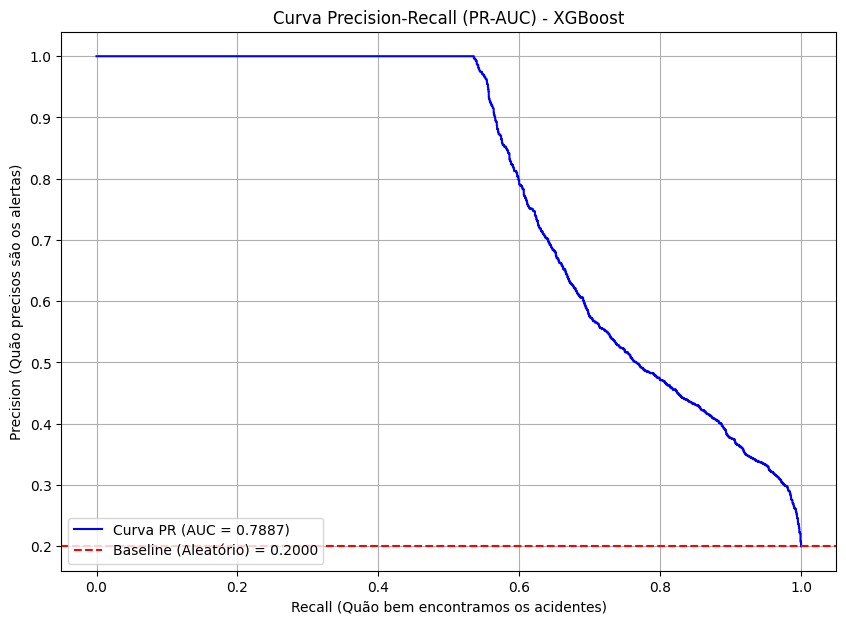

In [7]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Curvas Precision-Recall (PR-AUC) 1_10

Average Precision (AP) / PR-AUC: 0.7161


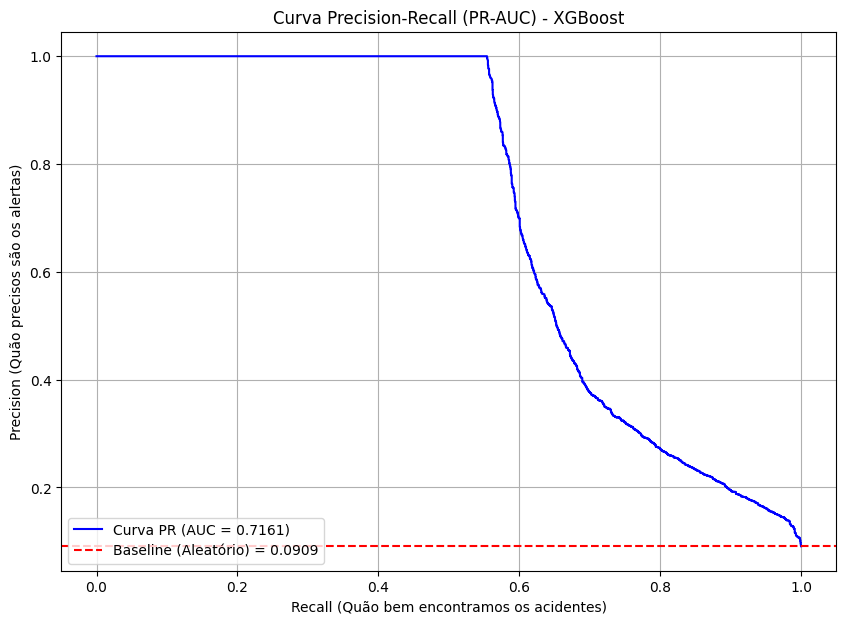

In [24]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Curvas Precision-Recall (PR-AUC) 1_20

Average Precision (AP) / PR-AUC: 0.6676


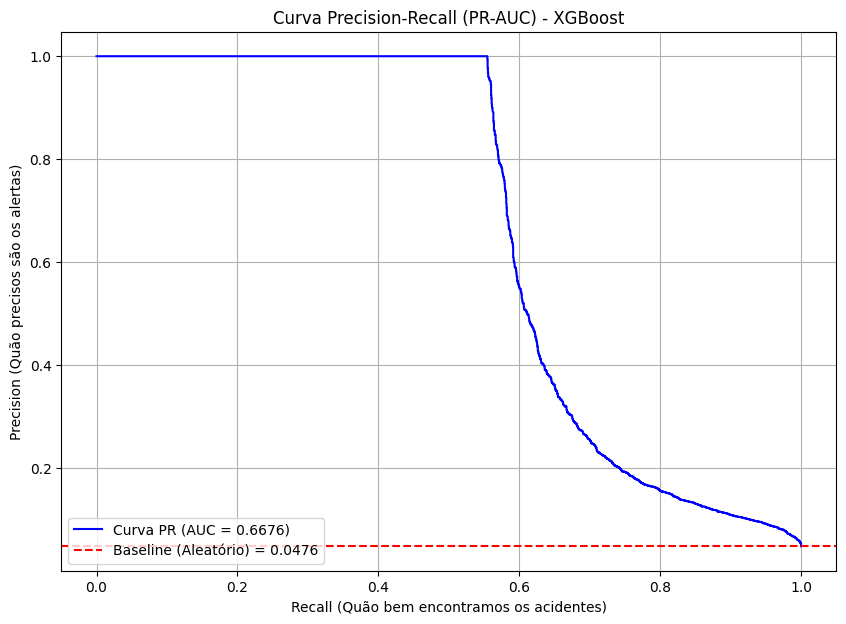

In [30]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Curvas Precision-Recall (PR-AUC) 1_50

Average Precision (AP) / PR-AUC: 0.6233


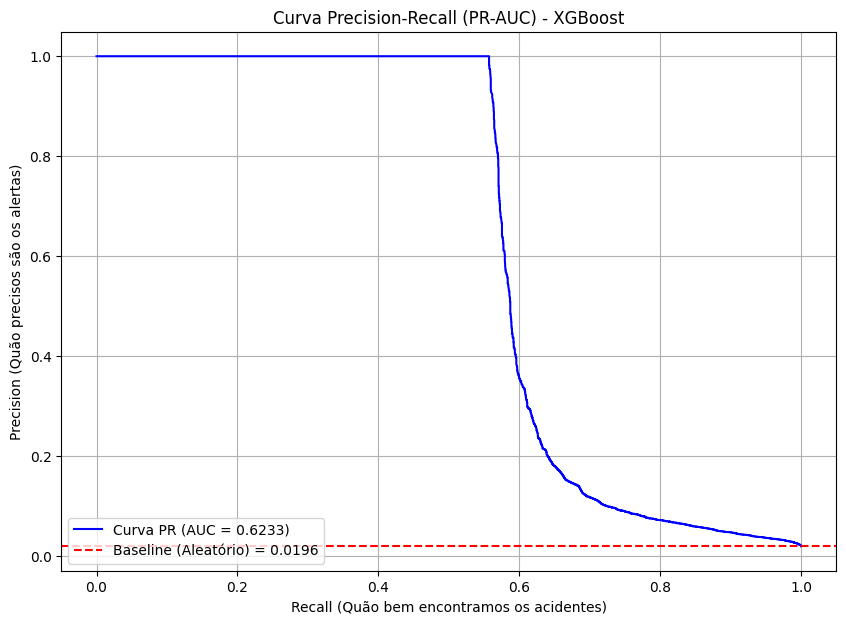

In [36]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Curvas Precision-Recall (PR-AUC) 1_100

Average Precision (AP) / PR-AUC: 0.8623


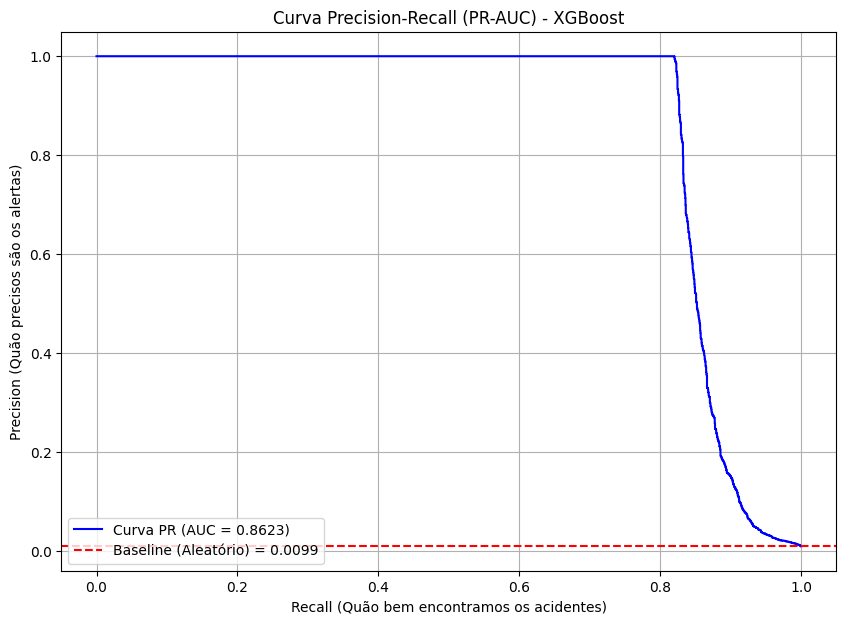

In [6]:
# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva Precision-Recall (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# 4. Plotar o gráfico da Curva Precision-Recall
plt.figure(figsize=(10, 7))

# Plota a curva PR
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# 5. Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente (proporção de positivos)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()